#Import Libraries

In [ ]:
# %%capture
%%bash
apt-get install cmake
apt-get install zlib1g-dev
pip install JSAnimation
pip install gym-super-mario-bros

Reading package lists...
Building dependency tree...
Reading state information...
cmake is already the newest version (3.22.1-1ubuntu1.22.04.2).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
Reading package lists...
Building dependency tree...
Reading state information...
zlib1g-dev is already the newest version (1:1.2.11.dfsg-2ubuntu9.2).
zlib1g-dev set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for JSAnimation: filename=JSAnimation-0.1-py3-none-any.whl size=11405 sha256=d89ee76823e0d91bf2c67bbe04c7ae790ab715947351f9cd284bc12faf362804
  Stored in directory: /root/.cache/pip/wheels/1e/16/64/028f540fe8f5eae5026a423bfd88356248074379b79f27b646
Successfully built JSAnimation
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.7/77.7 kB

In [ ]:
import numpy as np
# import cPickle as pickle
import matplotlib.pyplot as plt
#from JSAnimation.IPython_display import display_animation
from IPython.display import Image
from matplotlib import animation

from collections import deque

%matplotlib inline

In [ ]:
from nes_py.wrappers import JoypadSpace
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT

#Environment

In [ ]:
# We will be initializing the environment using the following version: SuperMarioBros-v0
env = gym_super_mario_bros.make('SuperMarioBros-v0')
env = JoypadSpace(env, SIMPLE_MOVEMENT)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment SuperMarioBros-v0 is out of date. You should consider upgrading to version `v3`.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which re

In [ ]:
# Let's take a look on the action_space
action_space = env.get_action_meanings()
#action_space.remove('right A B')
action_space

['NOOP', 'right', 'right A', 'right B', 'right A B', 'A', 'left']

'NOOP': This action means the agent does nothing. It's equivalent to not pressing any buttons on the controller.

'right': This action makes Mario move to the right.

'right A': This action makes Mario to the right while jumping.

'right B': This action makes Mario moves to the right while shooting fireballs.

'right A B': This action makes Mario moves to the right while jumping, and shooting fieballs.

'A': This action makes Mario jump.

'left': This action makes Mario move to the left.


#Random Policy

In [ ]:
# The agent will play here using random policy.

def preprocess(frame):
    frame = frame.sum(axis=-1)/765
    frame = frame[20:210,:]
    frame = frame[::2,::2]
    return frame


observation = env.reset()
r = []
infos = []
MAX_STEPS = 500
frames = np.zeros((MAX_STEPS, 240, 256, 3), dtype=np.uint8)
xs = []
valid_actions = [1,5,6]
for step in range(MAX_STEPS):
    # Render into buffer.
    frames[step] = env.render(mode = 'rgb_array')
    observation, reward, done, info = env.step(valid_actions[np.random.randint(3)]) #
    infos.append(info)
    r.append(reward)
    xs.append(info['x_pos'])
    if done:
        break

r = np.array(r)


/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:280: UserWarning: WARN: No render modes was declared in the environment (env.metadata['render_modes'] is None or not defined), you may have trouble when calling `.render()`.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinsta

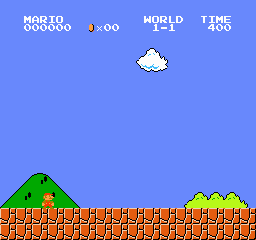

In [ ]:
import imageio
from IPython.display import display, Image

images = []

for frame in frames:
    images.append(frame)

imageio.mimsave('Mario_random.gif', images, duration=0.05)
gif_path = 'Mario_random.gif'

display(Image(filename=gif_path))

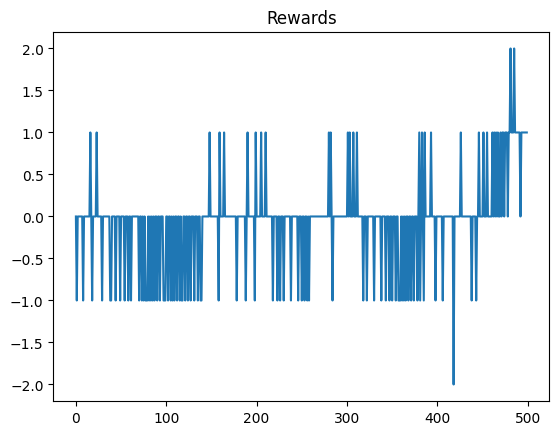

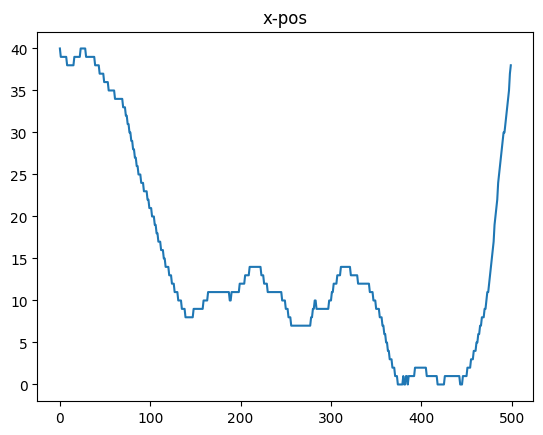

Sum of rewards is  -27.0


In [ ]:
plt.plot(r)
plt.title('Rewards')
plt.show()

plt.plot(xs)
plt.title('x-pos')
plt.show()

print('Sum of rewards is ', r.sum())

# Models

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class QNetworkCNN(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, channels, action_size, seed=42):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
        """
        super(QNetworkCNN, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.conv1 = nn.Conv2d(channels, 4, 3, padding=1)
        self.conv2 = nn.Conv2d(4, 8, 3, padding=1)
        self.conv3 = nn.Conv2d(8, 16, 3, padding=1)
        self.conv4 = nn.Conv2d(16, 16, 3, padding=1)
        self.conv5 = nn.Conv2d(16, 16, 3, padding=1)

        self.pool = nn.MaxPool2d(2, ceil_mode=True)

        flat_len = 16*3*4
        self.fc1 = nn.Linear(flat_len, 20)
        self.fc2 = nn.Linear(20, action_size)

    def forward(self, x):
        """Build a network that maps state -> action values."""
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))

        x = x.reshape(x.shape[0], -1)

        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

class QNetworkDuellingCNN(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, channels, action_size, seed=42):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
        """
        super(QNetworkDuellingCNN, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.conv1 = nn.Conv2d(channels, 4, 3, padding=1)
        self.conv2 = nn.Conv2d(4, 8, 3, padding=1)
        self.conv3 = nn.Conv2d(8, 16, 3, padding=1)
        self.conv4 = nn.Conv2d(16, 16, 3, padding=1)
        self.conv5 = nn.Conv2d(16, 16, 3, padding=1)

        self.pool = nn.MaxPool2d(2, ceil_mode=True)

        flat_len = 16*3*4
        self.fcval = nn.Linear(flat_len, 20)
        self.fcval2 = nn.Linear(20, 1)
        self.fcadv = nn.Linear(flat_len, 20)
        self.fcadv2 = nn.Linear(20, action_size)

    def forward(self, x):
        """Build a network that maps state -> action values."""
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))

        x = x.reshape(x.shape[0], -1)

        advantage = F.relu(self.fcadv(x))
        advantage = self.fcadv2(advantage)
        advantage = advantage - torch.mean(advantage, dim=-1, keepdim=True)

        value = F.relu(self.fcval(x))
        value = self.fcval2(value)

        return value + advantage

# Memory buffer
Saves States, Actions, Rewards, Next States (SARS) and Dones.

If priority sampling is required, we sample according to the error of the model.

In [ ]:
import torch
import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, state_size, action_size, buffer_size, batch_size, priority=False):
        """Initialize a ReplayBuffer object.
        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer (chosen as multiple of num agents)
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.states = torch.zeros((buffer_size,)+state_size).to(device)
        self.next_states = torch.zeros((buffer_size,)+state_size).to(device)
        self.actions = torch.zeros(buffer_size,1, dtype=torch.long).to(device)
        self.rewards = torch.zeros(buffer_size, 1, dtype=torch.float).to(device)
        self.dones = torch.zeros(buffer_size, 1, dtype=torch.float).to(device)
        self.e = np.zeros((buffer_size, 1), dtype=float)

        self.priority = priority

        self.ptr = 0
        self.n = 0
        self.buffer_size = buffer_size
        self.batch_size = batch_size

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        self.states[self.ptr] = torch.from_numpy(state).to(device)
        self.next_states[self.ptr] = torch.from_numpy(next_state).to(device)
        self.actions[self.ptr] = action
        self.rewards[self.ptr] = reward
        self.dones[self.ptr] = done

        self.ptr += 1
        if self.ptr >= self.buffer_size:
            self.ptr = 0
            self.n = self.buffer_size

    def sample(self, get_all=False):
        """Randomly sample a batch of experiences from memory."""
        n = len(self)
        if get_all:
            return self.states[:n], self.actions[:n], self.rewards[:n], self.next_states[:n], self.dones[:n]
        # else:
        if self.priority:
            idx = np.random.choice(n, self.batch_size, replace=False, p=self.e)
        else:
            idx = np.random.choice(n, self.batch_size, replace=False)

        states = self.states[idx]
        next_states = self.next_states[idx]
        actions = self.actions[idx]
        rewards = self.rewards[idx]
        dones = self.dones[idx]

        return (states, actions, rewards, next_states, dones), idx

    def update_error(self, e, idx=None):
        e = torch.abs(e.detach())
        e = e / e.sum()
        if idx is not None:
            self.e[idx] = e.cpu().numpy()
        else:
            self.e[:len(self)] = e.cpu().numpy()

    def __len__(self):
        if self.n == 0:
            return self.ptr
        else:
            return self.n

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Agent

In [ ]:
import numpy as np
import random
from collections import namedtuple, deque
import itertools

import torch
import torch.nn.functional as F
import torch.optim as optim

# from ReplayBuffer import ReplayBuffer

BUFFER_SIZE = int(5e3)  # replay buffer size
BATCH_SIZE = 256         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate
UPDATE_EVERY = 10        # how often to update the network

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class DQNAgent():
    """Interacts with and learns from the environment."""

    def __init__(self, model, state_size, action_size, seed=42, ddqn=False, priority=False):
        """Initialize an Agent object.

        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        self.ddqn = ddqn

        # Q-Network
        self.qnetwork_local = model(state_size[0], action_size, seed).to(device)
        self.qnetwork_target = model(state_size[0], action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(state_size, (action_size,), BUFFER_SIZE, BATCH_SIZE)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0

    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)

        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences, idx = self.memory.sample()
                e = self.learn(experiences)
                self.memory.update_error(e, idx)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.

        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def update_error(self):
        states, actions, rewards, next_states, dones = self.memory.sample(get_all=True)
        with torch.no_grad():
            if self.ddqn:
                old_val = self.qnetwork_local(states).gather(-1, actions)
                actions = self.qnetwork_local(next_states).argmax(-1, keepdim=True)
                maxQ = self.qnetwork_target(next_states).gather(-1, actions)
                target = rewards+GAMMA*maxQ*(1-dones)
            else: # Normal DQN
                maxQ = self.qnetwork_target(next_states).max(-1, keepdim=True)[0]
                target = rewards+GAMMA*maxQ*(1-dones)
                old_val = self.qnetwork_local(states).gather(-1, actions)
            e = old_val - target
            self.memory.update_error(e)

    def learn(self, experiences):
        """Update value parameters using given batch of experience tuples.
        Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        ## compute and minimize the loss
        self.optimizer.zero_grad()
        if self.ddqn:
            old_val = self.qnetwork_local(states).gather(-1, actions)
            with torch.no_grad():
                next_actions = self.qnetwork_local(next_states).argmax(-1, keepdim=True)
                maxQ = self.qnetwork_target(next_states).gather(-1, next_actions)
                target = rewards+GAMMA*maxQ*(1-dones)
        else: # Normal DQN
            with torch.no_grad():
                maxQ = self.qnetwork_target(next_states).max(-1, keepdim=True)[0]
                target = rewards+GAMMA*maxQ*(1-dones)
            old_val = self.qnetwork_local(states).gather(-1, actions)

        loss = F.mse_loss(old_val, target)
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)

        return old_val - target


    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

# Train Agent
We step through different iterations of the environment to learn the optimal action for a given state.

In [ ]:
episode = 100
discount_rate = .99
noise = 0.05
noise_decay = 0.99
tmax = 500

# keep track of progress
sum_rewards = []

# keep track of frames
FRAME_SHAPE = (95, 128)
MAX_FRAMES = 4
nn_frames = deque(maxlen=MAX_FRAMES)
for i in range(MAX_FRAMES):
    nn_frames.append(np.zeros(FRAME_SHAPE))

action_size = 7 #len(valid_actions)
state_size = (MAX_FRAMES,) + FRAME_SHAPE
agent = DQNAgent(QNetworkDuellingCNN, state_size, action_size, ddqn=True, priority=True)

for e in range(episode):
    obs = env.reset()
    prev_obs = None
    sum_reward = 0

    for i in range(MAX_FRAMES):
        nn_frames.append(np.zeros(FRAME_SHAPE))
    nn_frames.append(np.copy(preprocess(obs)))
    states = np.array(nn_frames)
    for t in range(tmax):
        actions = agent.act(states, noise)
        obs, reward, done, _ = env.step(actions)
        nn_frames.append(np.copy(preprocess(obs)))
        next_states = np.array(nn_frames)

        agent.step(states, int(actions), int(reward), next_states, int(done))
        sum_reward += reward
        states = next_states

        if done or reward < -10:
            break

    agent.update_error()
    sum_rewards.append(sum_reward)
    noise = noise * noise_decay

    print('\rEpisode {}\tCurrent Score: {:.2f}'.format(e, sum_rewards[-1]), end="")
    # display some progress every 20 iterations
    if (e+1) % (episode // 20) ==0:
        print(" | Episode: {0:d}, average score: {1:f}".format(e+1,np.mean(sum_rewards[-20:])))

Episode 4	Current Score: 369.00 | Episode: 5, average score: 219.400000
Episode 9	Current Score: 252.00 | Episode: 10, average score: 259.000000
Episode 14	Current Score: 252.00 | Episode: 15, average score: 264.066667
Episode 19	Current Score: 252.00 | Episode: 20, average score: 274.200000
Episode 24	Current Score: 529.00 | Episode: 25, average score: 335.800000
Episode 29	Current Score: 128.00 | Episode: 30, average score: 384.500000
Episode 34	Current Score: 250.00 | Episode: 35, average score: 453.050000
Episode 39	Current Score: 646.00 | Episode: 40, average score: 546.300000
Episode 44	Current Score: 626.00 | Episode: 45, average score: 588.400000
Episode 49	Current Score: 617.00 | Episode: 50, average score: 617.750000
Episode 54	Current Score: 249.00 | Episode: 55, average score: 623.850000
Episode 59	Current Score: 636.00 | Episode: 60, average score: 592.200000
Episode 64	Current Score: 657.00 | Episode: 65, average score: 574.450000
Episode 69	Current Score: 685.00 | Episod

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


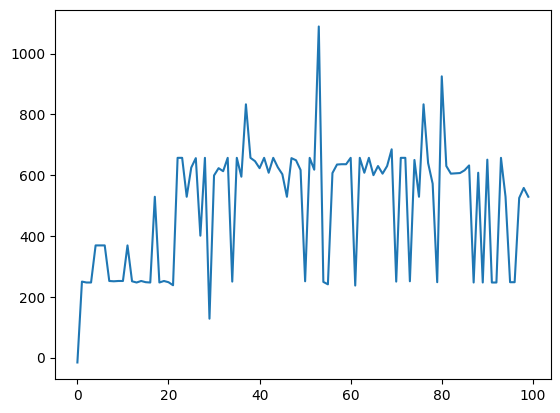

In [ ]:
plt.plot(sum_rewards)
plt.show()

In [ ]:
obs = env.reset()
prev_obs = None
sum_reward = 0

frames = np.zeros((tmax, 240, 256, 3), dtype=np.uint8)
for i in range(MAX_FRAMES):
  nn_frames.append(np.zeros(FRAME_SHAPE))
nn_frames.append(np.copy(preprocess(obs)))
states = np.array(nn_frames)
rs = []
xs = []
ys = []
for t in range(tmax):
    frames[t] = obs
    actions = agent.act(states, noise)
    obs, reward, done, info = env.step(actions)
    nn_frames.append(np.copy(preprocess(obs)))
    next_states = np.array(nn_frames)

    sum_reward += reward
    states = next_states
    rs.append(reward)
    xs.append(info['x_pos'])
    ys.append(info['y_pos'])
    if done:
        break

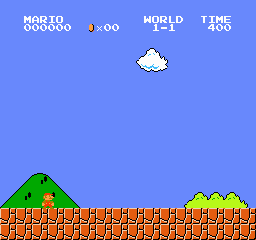

In [ ]:
import imageio
from IPython.display import display, Image

images = []

for frame in frames:
    images.append(frame)

imageio.mimsave('Mario_trained.gif', images, duration=0.05)
gif_path = 'Mario_trained.gif'

display(Image(filename=gif_path))

Sum of rewards is  649.0


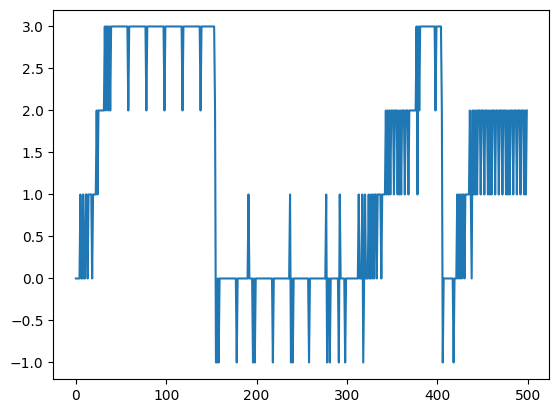

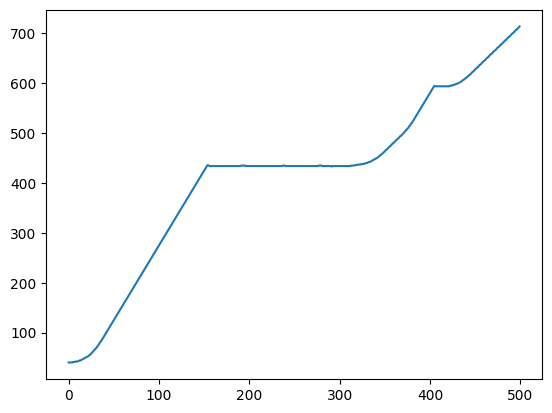

In [ ]:
print('Sum of rewards is ', sum(rs))
plt.plot(rs)
plt.show()

plt.plot(xs)
plt.show()